# Attention in Transformers

## Dot Product

The dot product allows us to calculate the similarity between two vectors. In scaled dot-product attention, this is used to determine how similar a **Query** vector for one token is to the **Key** vector of another token.

The dot product is calculated by multiplying each component of two vectors, then summing each of them.

$$
\begin{align*}
\vec{a} = [a_{1}, a_{2}, a_{3}, ..., a_{n}] \\
\vec{b} = [b_{1}, b_{2}, b_{3}, ..., b_{n}] \\
\vec{a} \cdot \vec{b} = a_{1}b_{1} + a_{2}b_{2} + a_{3}b_{3} + ... + a_{n}b_{n} \\
\end{align*}
$$

or

$$\vec{a} \cdot \vec{b} = \sum_{i=1}^{n}a_{i}b_{i}$$

This can also be written as matrix multiplying between vector $a$ and the transform of vector $b$



In [1]:
import numpy as np
import pandas as pd
import visualization as vis

np.random.seed(42)

a = np.random.random(5)
b = np.random.random(5)
dot_product = [i*x for i, x in zip(a, b)]

print(f"a = {a}")
print(f"b = {b}")
print()
for i, product in enumerate(dot_product):
    print(f"{a[i]:.2f} * {b[i]:.2f} = {product:.2f}")

print("___________________")
print(f"              {sum(dot_product):.2f}")

a = [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
b = [0.15599452 0.05808361 0.86617615 0.60111501 0.70807258]

0.37 * 0.16 = 0.06
0.95 * 0.06 = 0.06
0.73 * 0.87 = 0.63
0.60 * 0.60 = 0.36
0.16 * 0.71 = 0.11
___________________
              1.22


This gives us the similarity between the two vectors. 

We can also calculate the dot product in Numpy using `np.dot(a, b)`

In [2]:
print(f"{np.dot(a, b):.2f}")

1.22


## Scaled Dot-Product Attention

Let's look at how we can calculate the dot product between matrices built using multiple Key - Query vectors.

In [3]:
# Start with an example sentence. Each word will be a token and get a key and query vector
example_sentence="machine learning is fun".split()
print(f"Example sentence split by word: {example_sentence}")

# We map each word to an index
word_to_idx = dict([(example_sentence[i], i) for i in range(len(example_sentence))])
print(f"\nWord to index mapping: {word_to_idx}")

# Next, we can build key, query, and value vectors with 5 random numbers per word
# Each ROW corresponds to a WORD and each COLUMN corresponds to an EMBEDDING
EMBEDDING_DIM=6
CONTEXT_LENGTH=len(example_sentence)
query_vectors = np.array([np.random.random(EMBEDDING_DIM) for i in example_sentence])
key_vectors = np.array([np.random.random(EMBEDDING_DIM) for i in example_sentence])
value_vectors = np.array([np.random.random(EMBEDDING_DIM) for i in example_sentence])

column_map = {i: f"Dim {i+1}" for i in range(EMBEDDING_DIM)}

# Let's print out the words and their embeddings
def convert_embedding_to_df(matrix, word_to_idx):
    """Helper function to convert a matrix where each row is a word embedding to a Pandas df"""
    matrix_df = pd.DataFrame()

    for i, word in enumerate(word_to_idx):
        matrix_df[word] = matrix[i]

    matrix_df = matrix_df.T.rename(columns=column_map)
    
    return matrix_df

print("\nQuery Matrix:")
query_vector_df = convert_embedding_to_df(query_vectors, word_to_idx)
print(query_vector_df.head())

print("\nKey Matrix:")
key_vector_df = convert_embedding_to_df(key_vectors, word_to_idx)
print(key_vector_df.head())


Example sentence split by word: ['machine', 'learning', 'is', 'fun']

Word to index mapping: {'machine': 0, 'learning': 1, 'is': 2, 'fun': 3}

Query Matrix:
             Dim 1     Dim 2     Dim 3     Dim 4     Dim 5     Dim 6
machine   0.020584  0.969910  0.832443  0.212339  0.181825  0.183405
learning  0.304242  0.524756  0.431945  0.291229  0.611853  0.139494
is        0.292145  0.366362  0.456070  0.785176  0.199674  0.514234
fun       0.592415  0.046450  0.607545  0.170524  0.065052  0.948886

Key Matrix:
             Dim 1     Dim 2     Dim 3     Dim 4     Dim 5     Dim 6
machine   0.965632  0.808397  0.304614  0.097672  0.684233  0.440152
learning  0.122038  0.495177  0.034389  0.909320  0.258780  0.662522
is        0.311711  0.520068  0.546710  0.184854  0.969585  0.775133
fun       0.939499  0.894827  0.597900  0.921874  0.088493  0.195983


Now that we have the query and key matrices, we want to get the **Dot Product** between the Query and Key vectors for each word. As above, we want to calculate $query_{1}key_{1} + query_{2}key_{2} + ... + query_{n}key_{n}$. To do this, we need to **Transpose** the key matrix. Otherwise, the matrix multiplication would multiply each row of the query matrix with each column of the value matrix, which is not what we want.

$$\vec{\text{Query}} \cdot \vec{\text{Key}} = \text{Query} \times \text{Key}^{T}$$

In [4]:
matrix_dot_product = np.dot(query_vectors, key_vectors.T)

# We can represent the result as the similarity between each words Query vector to each other words Key vector
def convert_query_key_dot_product_to_df(matrix_dot_product, word_to_idx):
    return pd.DataFrame(data=matrix_dot_product, index=[i for i in word_to_idx], columns =[i for i in word_to_idx])
matrix_dot_product_df = convert_query_key_dot_product_to_df(matrix_dot_product, word_to_idx)
print(matrix_dot_product_df)

           machine  learning        is       fun
machine   1.283399  0.873062  1.323650  1.632743
learning  1.358068  0.827404  1.359098  1.363621
is        1.156850  1.339090  1.268280  1.717269
fun       1.273492  0.916744  1.371078  1.310313


The results of this matrix are then scaled by dividing the dot product by the square root of the number of embedding dimensions for the keys, or $d_{k}$. Each key consists of a vector of 5 numbers, so we would divide by the square root of 5. This scaling is done to counteract the vanishing gradient effects of calculating softmax values for large values of $d_{k}$.

In [5]:
scaled_matrix_dot_product = matrix_dot_product / np.sqrt(EMBEDDING_DIM)
scaled_matrix_dot_product_df = convert_query_key_dot_product_to_df(scaled_matrix_dot_product, word_to_idx)
print(scaled_matrix_dot_product_df)

           machine  learning        is       fun
machine   0.523946  0.356426  0.540378  0.666564
learning  0.554429  0.337786  0.554849  0.556696
is        0.472282  0.546681  0.517773  0.701072
fun       0.519901  0.374259  0.559740  0.534933


A **Softmax** function is then applied to the scaled dot product matrix to isolate important values. The softmax function converts the values into a range of probabilities between 0-1.

           machine  learning        is       fun
machine   0.062476  0.052840  0.063511  0.072053
learning  0.064410  0.051864  0.064437  0.064556
is        0.059330  0.063913  0.062092  0.074583
fun       0.062224  0.053791  0.064753  0.063166


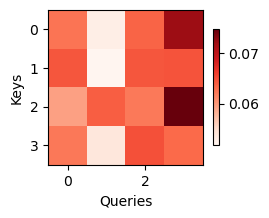

In [6]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

attention_weights = softmax(scaled_matrix_dot_product)
attention_weights_df = convert_query_key_dot_product_to_df(attention_weights, word_to_idx)
print(attention_weights_df)

# We can also represent the similarities between the queries and keys as a heatmap
vis.show_heatmaps(attention_weights.reshape((1, 1, 4, 4)), "Queries", "Keys")

This matrix, called the **attention value** matrix, represents how similar each word is to one another based on their Query and Key vectors. These are learned from the data, which allows the algorithm to learn to associate similar words. 

The matrix of value vectors are then used as weights for the value vector. You can think of the Keys and Queries as asking, "which of the words are most relevant to one another?", while the value is relevant return value. For translation, the value might correspond to a word in a different language. If the Query for the word "machine" matches closely with the Key for "learning", and the value for "learning" in a trained German translation model would correspond with "lernen".

In summary, Queries as the question: "where is the information that's relevent to me?" the Keys answer: "I am ___ relevant to you" and the Values contain the information that is passed forward.

In [7]:
attention_output = np.matmul(attention_weights, value_vectors)

attention_output_df = convert_embedding_to_df(attention_output, word_to_idx)
print("Attention Output:")
print(attention_output_df)

Attention Output:
             Dim 1     Dim 2     Dim 3     Dim 4     Dim 5     Dim 6
machine   0.122289  0.066957  0.057909  0.119481  0.162798  0.165646
learning  0.117035  0.066686  0.055841  0.119109  0.158512  0.161375
is        0.126112  0.071848  0.059146  0.126645  0.162197  0.175994
fun       0.116649  0.066980  0.054766  0.120158  0.155868  0.161861


## Multi-headed attention

Before we move forward, let's define a more robust implementation of the attention block

In [8]:
def attention_block(query_matrix, key_matrix, value_matrix):
    matrix_dot_product = np.dot(query_matrix, key_matrix.T)                     # 1. Calculate Query / Key similarity matrix
    scaled_matrix_dot_product = matrix_dot_product / np.sqrt(EMBEDDING_DIM)     # 2. Scale by embedding size to avoid gradients vanishing
    attention_weights = softmax(scaled_matrix_dot_product)                      # 3. Softmax to get most important relationships btw each word
    attention_output = np.matmul(attention_weights, value_matrix)               # 4. Get the values between each feature scaled by the importance
    return attention_output

Let's make sure this function is still giving the same output as before

In [9]:
attention_func_output = attention_block(query_vectors, key_vectors, value_vectors)

attention_func_output_df = convert_embedding_to_df(attention_func_output, word_to_idx)
print("Attention Output:")
print(attention_func_output_df)

Attention Output:
             Dim 1     Dim 2     Dim 3     Dim 4     Dim 5     Dim 6
machine   0.122289  0.066957  0.057909  0.119481  0.162798  0.165646
learning  0.117035  0.066686  0.055841  0.119109  0.158512  0.161375
is        0.126112  0.071848  0.059146  0.126645  0.162197  0.175994
fun       0.116649  0.066980  0.054766  0.120158  0.155868  0.161861


The goal of multi-headed attention is to improve our model by giving itthe ability to focus on different aspects of the input that could be relevant to the overall context, then combining these insights together into a single, deeper understanding of the relationships between concepts. We accomplish this by passing the query, key, and value matrices through multiple attention functions called **attention heads** at once, then concatenating their outputs together. However, if we just pass in the same query, key, and value matrices into the attention heads then we will get the same output from each of them. To allow each head to focus on different aspects of the overall context, we pass the query, key, and value matrices through trainable **weight matrices**. These are called **independently learned linear projections**, as they are taking the values of the vector matrices and modifying them by different weights. The projects are passed into the attention heads, the output is concatenated, then a final linear projection produces the final output. The notation for this equation is:

$$
\begin{align*}
\text{MuliHead(Q, K, V)} = \text{Concat}(\text{head}_{1},...,\text{head}_{h})W^{O} \\
\text{where head}_{i} = \text{Attention}(QW_{i}^{Q}, Kw_{i}^{K}, VW_{i}^{V}) 
\end{align*}
$$

Where the projections are parameter matrices $W^{Q}_{i} \in \mathbb{R}^{d_{model} \times d_{k}} $, $W^{K}_{i} \in \mathbb{R}^{d_{model} \times d_{k}}$, $W^{V}_{i} \in \mathbb{R}^{d_{model} \times d_{v}}$ and $W^{O} \in \mathbb{R}^{hd_{v} \times d_{model}}$.

The original implementation of the transformer model used 8 attention heads. For this implementation, we will use 2 heads to keep things simple.

our $d_{model}$ value is the same as the embedding dimension of 6.

The information is split and passed to head head, with a size equal to the embedding size / number of heads.

Therefore, $d_{k} = d_{v} = d_{model} / h$ Since $d_{model}$ = 6 and we are using 2 heads, the dimensionality of $d_{k}$ and $d_{v}$ will be 6 x 3.

After contatenating the output from each of the heads, we multiply by a weight matrix of shape $(h * d_{v}) \times d_{model}$. We have 3 heads and the dimensionality of $d_{v}$ is 3, $(h * d_{v})$ = 6. Therefore, $W^{O}$ will be a 6 x 6 matrix.

The output from our multheaded attention is a 4 x 6 matrix, and $W^{O}$ is a 6 x 6 matrix, so the final output will be a 4 x 6 matrix.

Note that this process retains the dimensionality of the original input embedding.


In [10]:
NUM_ATTENTION_HEADS=2
import math
HEAD_SIZE = EMBEDDING_DIM // NUM_ATTENTION_HEADS # Specify the size of the embeddings (cols) for each head

def attention_head(query_matrix, key_matrix, value_matrix):
    # First, we need to set up random weight matrices for the linear projections
    query_weight_matrix = np.random.rand(EMBEDDING_DIM, HEAD_SIZE)       # embed x head size (6 x 3)
    key_weight_matrix = np.random.rand(EMBEDDING_DIM, HEAD_SIZE)         # embed x head size (6 x 3)
    value_weight_matrix = np.random.rand(EMBEDDING_DIM, HEAD_SIZE)       # embed x head size (6 x 3)

    # The query, key, and values are multiplied by their weight matrices
    query_linear_embed = np.matmul(query_vectors, query_weight_matrix)      # input x head size (4 x 3)
    key_linear_embed = np.matmul(key_vectors, key_weight_matrix)            # input x head size (4 x 3)
    value_linear_embed = np.matmul(value_vectors, value_weight_matrix)      # input x head size (4 x 3)
    
    # Then, these linear embeddings are passed through the attention block
    attention_output = attention_block(query_linear_embed, key_linear_embed, value_linear_embed) # input x head size (4 x 3)
    
    return attention_output

# Run attention heads and appended their outputs to a list
attention_head_output_list=[]
for i in range(NUM_ATTENTION_HEADS):
    attention_head_output = attention_head(query_vectors, key_vectors, value_vectors)
    attention_head_output_list.append(attention_head_output)

# The outputs from each attention head are concatenated together
concat_attention_head_output = np.concatenate(attention_head_output_list, axis=1) # input x (head size * num heads) (4 x 6)

# Finally, the concatenated output is multiplied by another linear projection weight matrix
num_rows = HEAD_SIZE * NUM_ATTENTION_HEADS  # (3 * 2) = 6
num_cols = EMBEDDING_DIM                    # 6

# 
output_weight_matrix = np.random.rand(num_rows, num_cols)   # (num heads * head size) x embed (6 x 6)
print(f"Output weight matrix shape: {output_weight_matrix.shape}")

multihead_attention_output = concat_attention_head_output @ output_weight_matrix

print(f"\nMultihead Attention Output:\n{multihead_attention_output}")
print(f"\nMultihead Attention output shape: {multihead_attention_output.shape}")

Output weight matrix shape: (6, 6)

Multihead Attention Output:
[[1.07043584 1.62960896 1.45838598 1.44572424 1.15413241 1.08176137]
 [0.82305966 1.27220231 1.13934366 1.11597382 0.88935979 0.83424004]
 [0.8847558  1.45890057 1.30822418 1.21902181 0.96378    0.90930374]
 [0.52724468 0.67842851 0.60493516 0.68558162 0.55757996 0.51625061]]

Multihead Attention output shape: (4, 6)
